In [486]:
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn import metrics
from xgboost import XGBClassifier

## Load Data

In [487]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [488]:
train[target].describe()

count    21000.000000
mean         0.085667
std          0.279878
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: damaged, dtype: float64

In [489]:
# We're looking at inbalanced data. About 8.5% of flights hit wildlife.

In [490]:
train.shape

(21000, 34)

In [493]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21000 entries, 0 to 20999
Data columns (total 34 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                21000 non-null  int64  
 1   incident_year     21000 non-null  int64  
 2   incident_month    21000 non-null  int64  
 3   incident_day      21000 non-null  int64  
 4   operator_id       21000 non-null  object 
 5   operator          21000 non-null  object 
 6   aircraft          21000 non-null  object 
 7   aircraft_type     16008 non-null  object 
 8   aircraft_make     15769 non-null  object 
 9   aircraft_model    14741 non-null  float64
 10  aircraft_mass     15306 non-null  float64
 11  engine_make       14845 non-null  float64
 12  engine_model      14666 non-null  object 
 13  engines           15304 non-null  float64
 14  engine_type       15297 non-null  object 
 15  engine1_position  15162 non-null  float64
 16  engine2_position  14224 non-null  float6

**NULL Observations**
- Test data has the same problem. would need to transform that too.
- Columns with no NULLS: ["id", "incident_year","incident_month","incident_day","operator_id","operator","aircraft","airport_id","species_id"]
- Columns with almost no Nulls: ["airport","species_name","species_quantity"'
- Lots of NULL values
   - Engine3 and 4 are most likely "censored" data. NULL because the plain did not have those engines

In [494]:
train.describe()

,id,incident_year,incident_month,incident_day,aircraft_model,aircraft_mass,engine_make,engines,engine1_position,engine2_position,engine4_position,height,speed,distance,damaged
count,21000.000000,21000.000000,21000.000000,21000.000000,14741.000000,15306.000000,14845.000000,15304.000000,15162.000000,14224.000000,350.000000,12531.000000,8642.000000,12087.000000,21000.000000
mean,14980.935667,2006.059048,7.186048,15.629476,24.645818,3.497321,21.222028,2.049007,2.992679,2.912753,2.017143,819.239965,141.393775,0.662865,0.085667
std,8663.241167,6.720905,2.794620,8.824230,21.702262,0.887106,11.037619,0.464322,2.094058,2.006015,1.430227,1772.530587,52.254614,3.333111,0.279878
min,1.000000,1990.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,7458.750000,2001.000000,5.000000,8.000000,10.000000,3.000000,10.000000,2.000000,1.000000,1.000000,1.000000,0.000000,120.000000,0.000000,0.000000
50%,14978.500000,2007.000000,8.000000,15.000000,22.000000,4.000000,22.000000,2.000000,1.000000,1.000000,1.000000,50.000000,137.000000,0.000000,0.000000
75%,22472.250000,2012.000000,9.000000,23.000000,37.000000,4.000000,34.000000,2.000000,5.000000,5.000000,4.000000,800.000000,160.000000,0.000000,0.000000
max,30000.000000,2015.000000,12.000000,31.000000,98.000000,5.000000,47.000000,4.000000,7.000000,7.000000,5.000000,24000.000000,2500.000000,100.000000,1.000000


## Visualizations

In [495]:
train

,id,incident_year,incident_month,incident_day,operator_id,operator,aircraft,aircraft_type,aircraft_make,aircraft_model,...,visibility,precipitation,height,speed,distance,species_id,species_name,species_quantity,flight_impact,damaged
0,23637,1996,11,7,MIL,MILITARY,T-1A,A,748,NaN,...,DAY,NaN,0.0,80.0,0.0,UNKBM,UNKNOWN MEDIUM BIRD,1,NaN,0
1,8075,1999,6,26,UAL,UNITED AIRLINES,B-757-200,A,148,26.0,...,NaN,NaN,NaN,NaN,NaN,UNKBM,UNKNOWN MEDIUM BIRD,1,NaN,1
2,5623,2011,12,1,SWA,SOUTHWEST AIRLINES,B-737-300,A,148,24.0,...,DAY,NONE,0.0,NaN,0.0,ZT002,WESTERN MEADOWLARK,1,NONE,0
3,19605,2007,9,13,SWA,SOUTHWEST AIRLINES,B-737-700,A,148,42.0,...,NIGHT,NONE,300.0,130.0,NaN,UNKBS,UNKNOWN SMALL BIRD,1,NONE,0
4,15142,2007,9,13,MIL,MILITARY,KC-135R,A,NaN,NaN,...,NIGHT,NaN,NaN,140.0,NaN,ZT105,BOBOLINK,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20995,6475,2005,12,10,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,M7005,AMERICAN COOT,1,NaN,0
20996,1824,2013,8,5,ASH,MESA AIRLINES,CRJ900,A,188,17.0,...,DAY,NONE,1200.0,145.0,NaN,UNKBS,UNKNOWN SMALL BIRD,2-10,NaN,0
20997,7800,2013,10,11,UNK,UNKNOWN,UNKNOWN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,0.0,O2205,MOURNING DOVE,1,NaN,0
20998,17294,2006,3,7,BUS,BUSINESS,C-172,A,226,7.0,...,DAY,NONE,200.0,73.0,NaN,O2205,MOURNING DOVE,1,PRECAUTIONARY LANDING,0


In [512]:
train[['id','incident_month','damaged']].groupby(['damaged','incident_month'], as_index=False).count()

,damaged,incident_month,id
0,0,1,610
1,0,2,602
2,0,3,911
3,0,4,1342
4,0,5,1881
5,0,6,1640
6,0,7,2482
7,0,8,2779
8,0,9,2659
9,0,10,2321


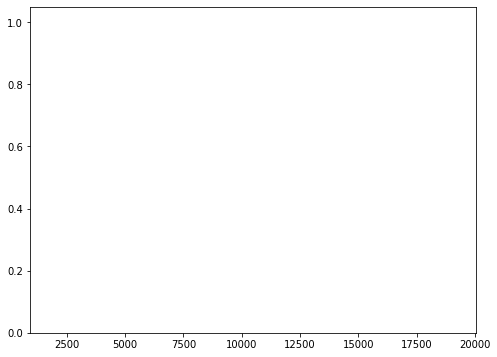

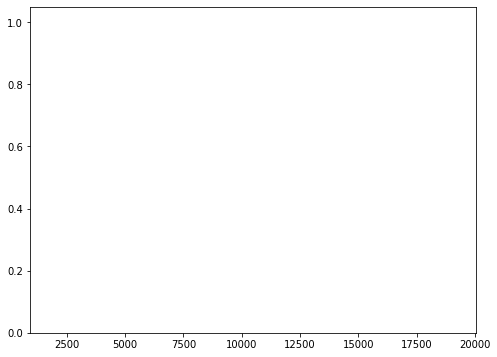

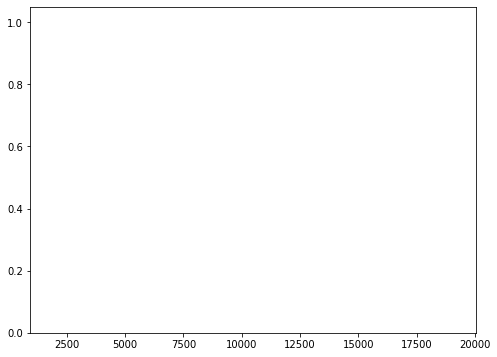

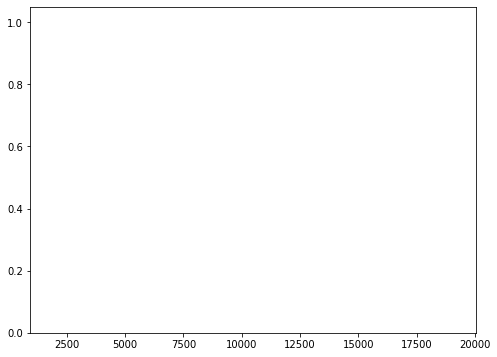

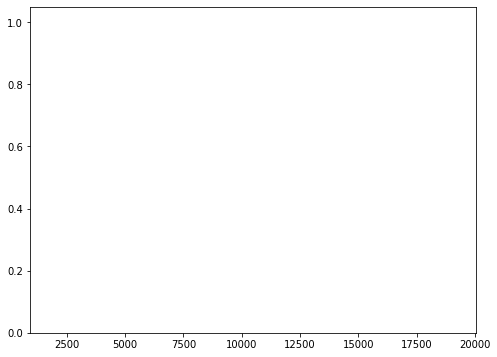

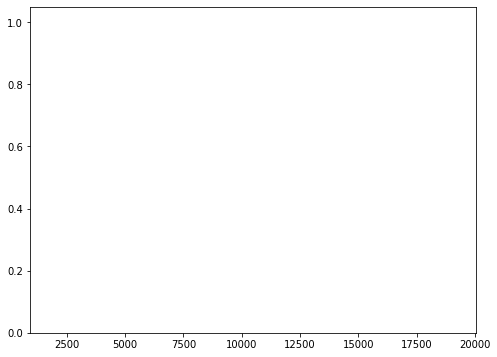

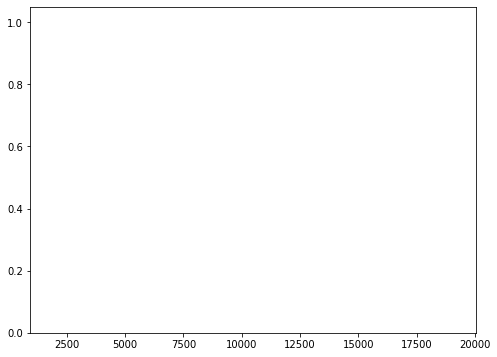

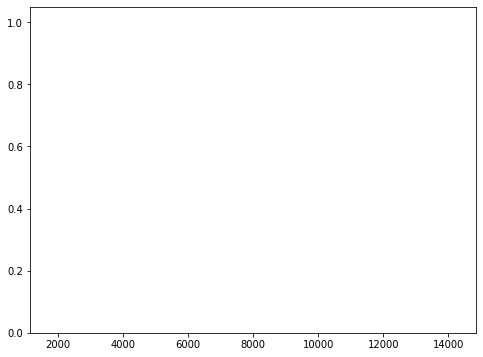

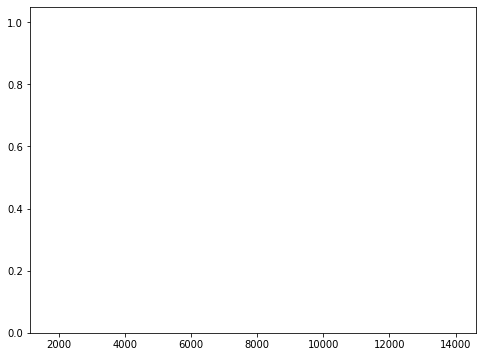

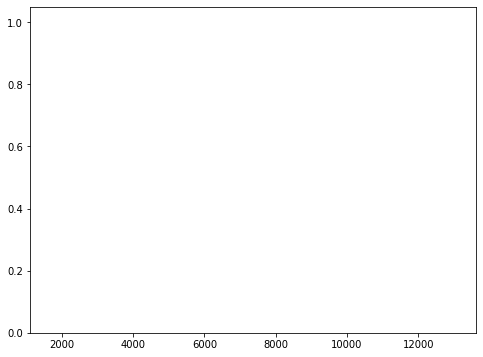

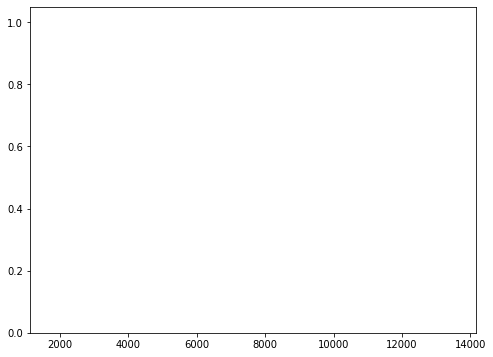

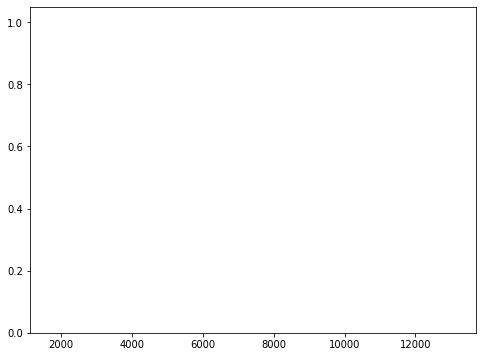

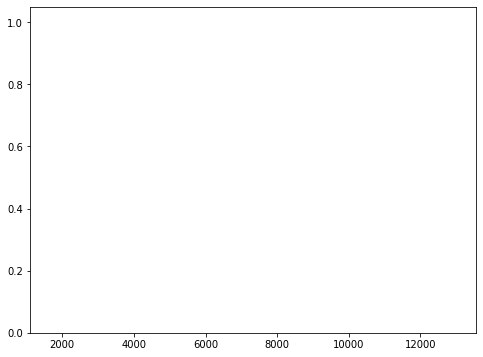

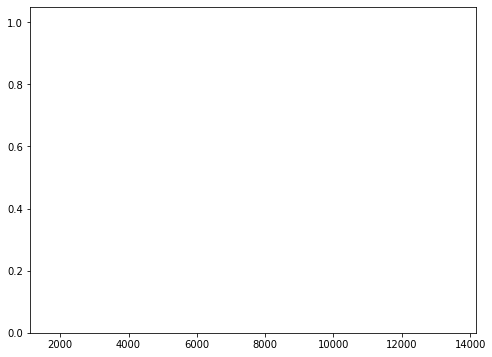

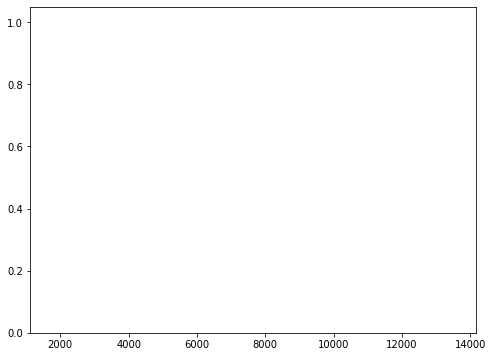

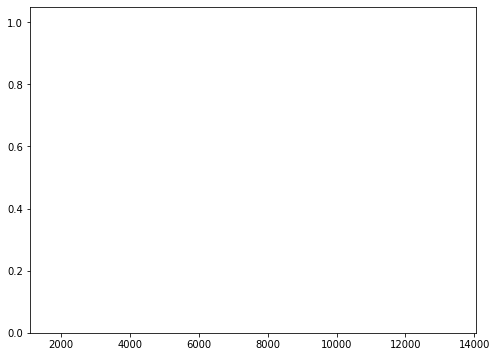

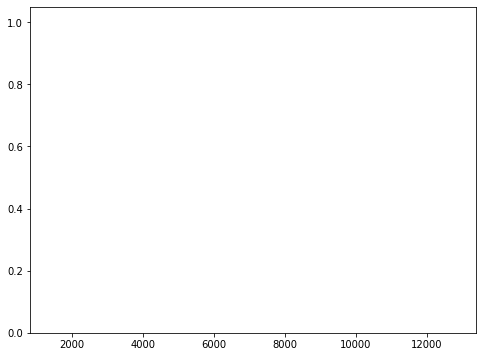

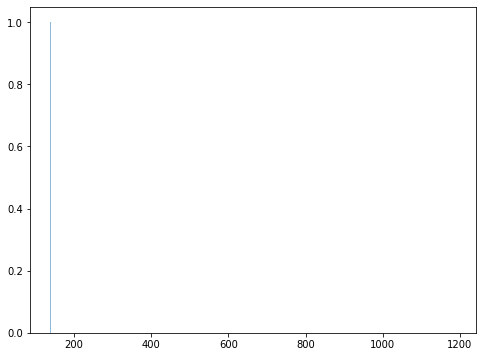

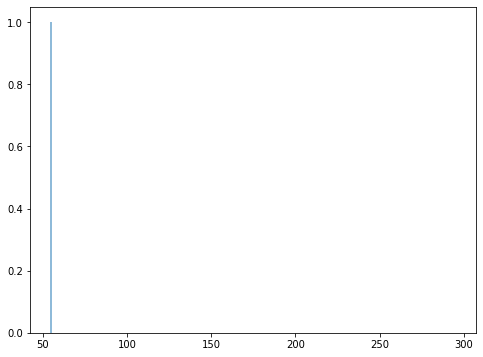

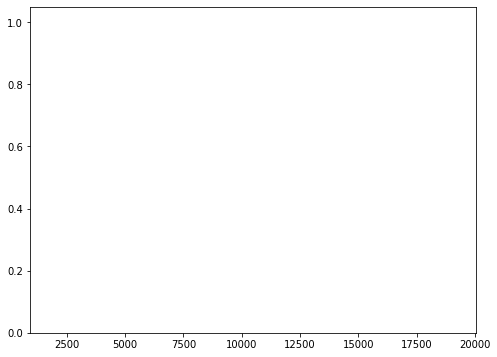

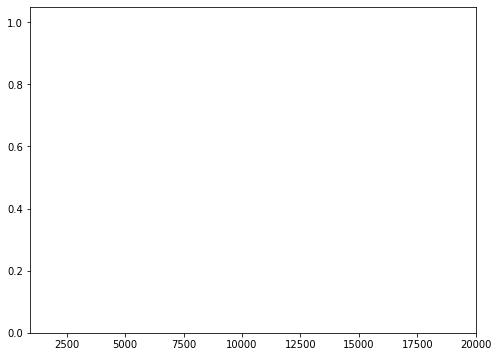

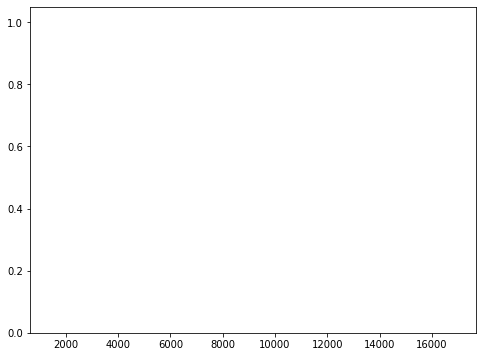

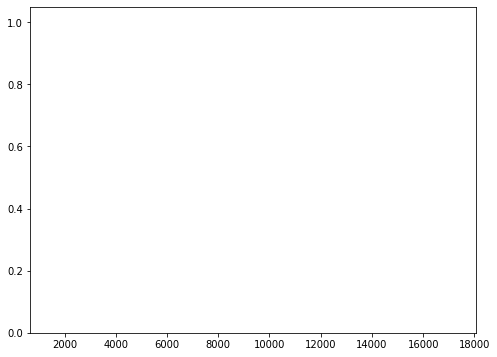

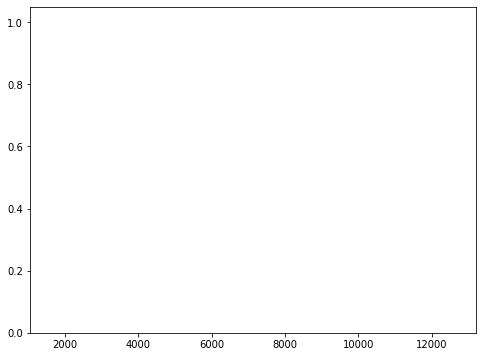

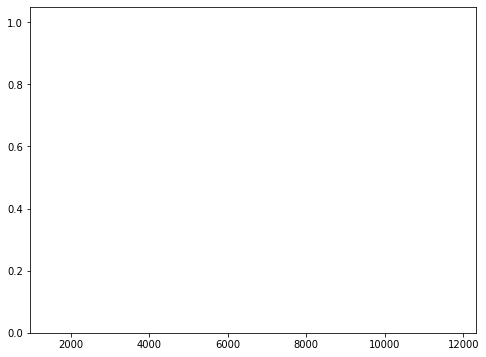

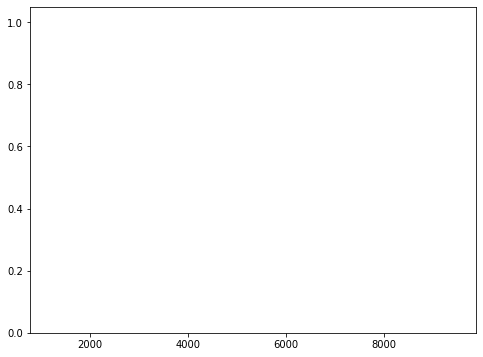

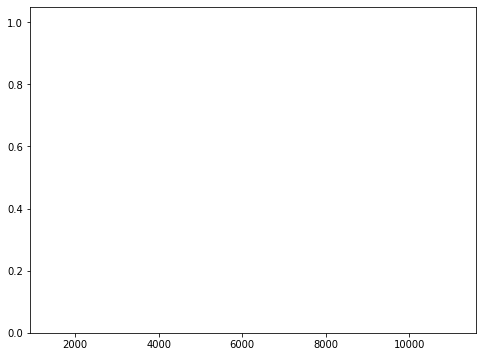

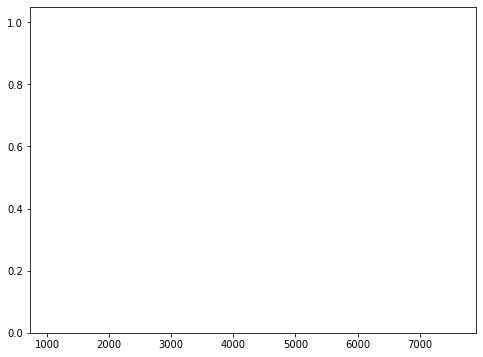

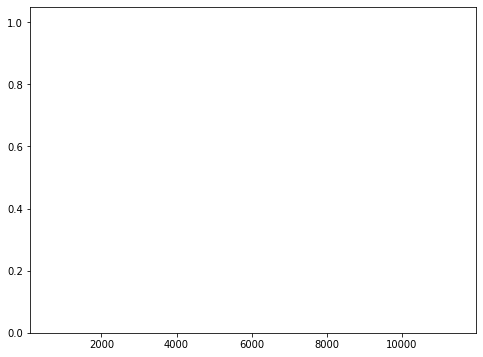

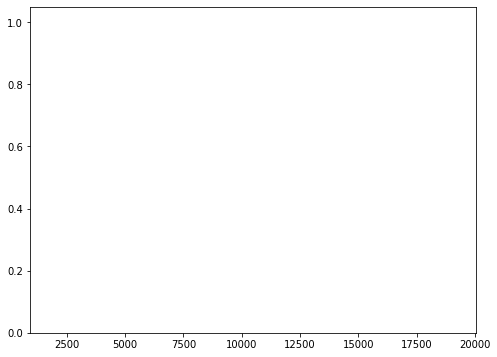

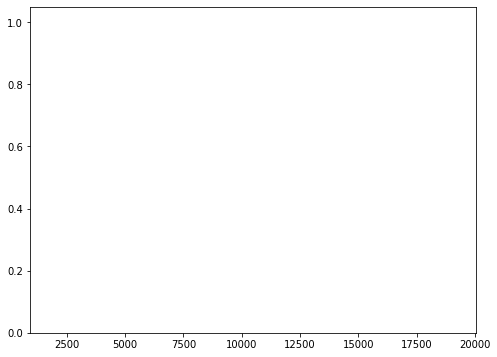

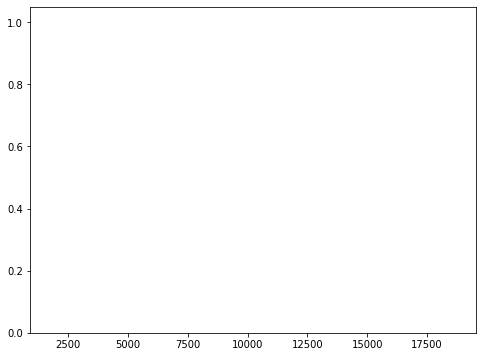

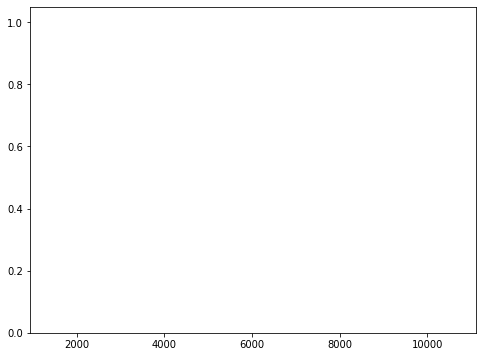

ValueError: Grouper for 'damaged' not 1-dimensional

In [510]:
for col in train.columns:
    temp = train[[col,'damaged']].groupby('damaged', as_index=False).count()
    plt.bar(temp[col].values, temp['damaged'].values, align='center', alpha=0.5)
    plt.show()
    

In [422]:
train.shape

(21000, 34)

In [423]:
temp.shape

(16008, 34)

In [424]:
#### Skewness

In [425]:
#### Null Values

In [426]:
#### Predictor Inbalance

# Pre-proccessing

In [492]:
train = train.replace('-1', np.nan)
train =train.replace(-1, np.nan)
train =train.replace(-1.0, np.nan)

In [443]:
def objects_to_category(df):
    '''
    function that converts objects to categorical features.
    '''
    object_cols = df.select_dtypes(include='object').columns.tolist()
    object_features = df[object_cols].astype("category")
    for field in object_cols:
        df[field] = object_features[field].cat.codes
    return df

# fill na
train = objects_to_category(train)
test = objects_to_category(test)

In [444]:
#train.fillna(-1)
#test.fillna(-1)

In [474]:
#fix engines
train[['engines','engine1_position','engine2_position','engine3_position','engine4_position']].head()


,engines,engine1_position,engine2_position,engine3_position,engine4_position
0,2.0,5.0,5.0,NaN,NaN
1,2.0,1.0,1.0,NaN,NaN
2,2.0,1.0,1.0,NaN,NaN
3,2.0,1.0,1.0,NaN,NaN
4,2.0,1.0,1.0,NaN,NaN


In [430]:
train.columns

Index(['id', 'incident_year', 'incident_month', 'incident_day', 'operator_id',
       'operator', 'aircraft', 'aircraft_type', 'aircraft_make',
       'aircraft_model', 'aircraft_mass', 'engine_make', 'engine_model',
       'engines', 'engine_type', 'engine1_position', 'engine2_position',
       'engine3_position', 'engine4_position', 'airport_id', 'airport',
       'state', 'faa_region', 'flight_phase', 'visibility', 'precipitation',
       'height', 'speed', 'distance', 'species_id', 'species_name',
       'species_quantity', 'flight_impact', 'damaged'],
      dtype='object')

# Basic Model

In [431]:
drop = ['damaged','id','operator_id','airport_id','species_id']
drop2 = ['id','operator_id','airport_id','species_id']
features = ["incident_year","incident_month","incident_day","operator","aircraft","airport_id","species_id"]
target =  'damaged'

#X = train[features]
X = train.drop(drop, axis=1)
y = train[target]
#submission = test[features]
submission = test.drop(drop2, axis=1)

In [432]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=40)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=1)

In [433]:
#View notbook for details on  Parameter Tuning
clf = XGBClassifier(max_depth=4,
                    min_child_weight=1,
                    learning_rate=0.1,
                    n_estimators=1000,
                    silent=True,
                    objective='binary:logistic',
                    gamma=4,
                    #max_delta_step=0,
                    #subsample=0.88,
                    #colsample_bytree=1,
                    #colsample_bylevel=1,
                    #reg_alpha=0,
                    #reg_lambda=0,
                    #scale_pos_weight=1,
                    seed=1,
                    #missing=None
                    )

clf.fit(
    X_train,
    y_train,
    eval_metric="logloss",
    eval_set=[(X_train, y_train), (X_val, y_val)], 
    verbose=True,
    early_stopping_rounds = 10
)

[00:14:59] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:541: 
Parameters: { silent } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[0]	validation_0-logloss:0.62286	validation_1-logloss:0.62277
[1]	validation_0-logloss:0.56529	validation_1-logloss:0.56534
[2]	validation_0-logloss:0.51747	validation_1-logloss:0.51741
[3]	validation_0-logloss:0.47737	validation_1-logloss:0.47743
[4]	validation_0-logloss:0.44350	validation_1-logloss:0.44337
[5]	validation_0-logloss:0.41459	validation_1-logloss:0.41422
[6]	validation_0-logloss:0.38974	validation_1-logloss:0.38928
[7]	validation_0-logloss:0.36801	validation_1-logloss:0.36740
[8]	validation_0-logloss:0.34941	validation_1-logloss:0.34873
[9]	val

/Users/neilturner/anaconda3/envs/python3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[23]	validation_0-logloss:0.23492	validation_1-logloss:0.23596
[24]	validation_0-logloss:0.23225	validation_1-logloss:0.23333
[25]	validation_0-logloss:0.22976	validation_1-logloss:0.23087
[26]	validation_0-logloss:0.22679	validation_1-logloss:0.22773
[27]	validation_0-logloss:0.22486	validation_1-logloss:0.22596
[28]	validation_0-logloss:0.22303	validation_1-logloss:0.22429
[29]	validation_0-logloss:0.22137	validation_1-logloss:0.22250
[30]	validation_0-logloss:0.21974	validation_1-logloss:0.22088
[31]	validation_0-logloss:0.21817	validation_1-logloss:0.21954
[32]	validation_0-logloss:0.21689	validation_1-logloss:0.21841
[33]	validation_0-logloss:0.21538	validation_1-logloss:0.21699
[34]	validation_0-logloss:0.21391	validation_1-logloss:0.21580
[35]	validation_0-logloss:0.21278	validation_1-logloss:0.21500
[36]	validation_0-logloss:0.21144	validation_1-logloss:0.21379
[37]	validation_0-logloss:0.21045	validation_1-logloss:0.21313
[38]	validation_0-logloss:0.20931	validation_1-logloss:

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=4, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.1, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=1000, n_jobs=12, num_parallel_tree=1,
              objective='binary:logistic', random_state=1, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=1, silent=True,
              subsample=1, tree_method='exact', use_label_encoder=True,
              validate_parameters=1, verbosity=None)

In [434]:
## Predictions

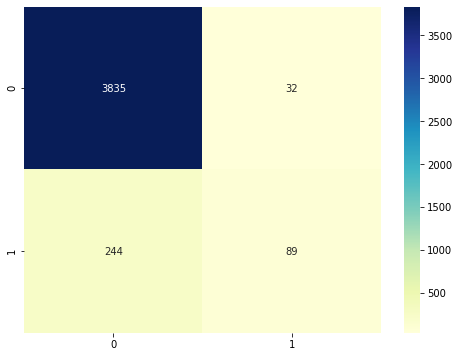

0.1896120319024582
0.9342857142857143
0.8737045812297946
0.052714104686880536
0.3920704845814978
0.2672672672672673
0.7355371900826446
0.254680252862071


In [435]:
# riding style null fixed
## Create Report
y_pred = clf.predict(X_test)
probs = clf.predict_proba(X_test)

results = pd.DataFrame(y_test)
#temp = pd.DataFrame(probs)
results['actual_classification'] = y_test
results['predicted_classification'] = y_pred
results['buy_prob_28'] = probs[:,1]

plt.rcParams["figure.figsize"] = (8, 6)
matrix = metrics.confusion_matrix(results['actual_classification'], results['predicted_classification'])
sns.heatmap(pd.DataFrame(matrix), annot=True, cmap="YlGnBu" ,fmt='g')
plt.show()
#classification summary stats
print(metrics.log_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.accuracy_score(results['actual_classification'], results['predicted_classification']))
print(metrics.roc_auc_score(results['actual_classification'],results['buy_prob_28']))
print(metrics.brier_score_loss(results['actual_classification'],results['buy_prob_28']))
print(metrics.f1_score(results['actual_classification'], results['predicted_classification']))
print(metrics.recall_score(results['actual_classification'], results['predicted_classification']))
print(metrics.precision_score(results['actual_classification'], results['predicted_classification']))
print(metrics.average_precision_score(results['actual_classification'], results['predicted_classification']))

In [436]:
## Make Submission
predictions = clf.predict_proba(submission)

In [437]:
pd.DataFrame(predictions)[0]

0       0.920104
1       0.926762
2       0.978351
3       0.857887
4       0.945931
          ...   
8995    0.930671
8996    0.928026
8997    0.984236
8998    0.477540
8999    0.864078
Name: 0, Length: 9000, dtype: float32

In [438]:
test['damaged'] = pd.DataFrame(predictions)[0]

In [439]:
submit = test[['id','damaged']]

In [440]:
submit

,id,damaged
0,11254,0.920104
1,27716,0.926762
2,29066,0.978351
3,3373,0.857887
4,1996,0.945931
...,...,...
8995,14194,0.930671
8996,14451,0.928026
8997,10560,0.984236
8998,23399,0.477540


In [441]:
submit.to_csv('data/submission.csv', index=False)

In [442]:
! kaggle competitions submit -c sliced-s01e02-xunyc5 -f 'data/submission.csv' -m "All features"

100%|█████████████████████████████████████████| 140k/140k [00:00<00:00, 165kB/s]
Successfully submitted to SLICED s01e02